<a href="https://colab.research.google.com/github/salonikhot123/saloni_info5731_fall2025/blob/main/INFO5731_Assignment_3_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# **INFO5731 Assignment 3**

In this assignment, we will delve into various aspects of natural language processing (NLP) and text analysis. The tasks are designed to deepen your understanding of key NLP concepts and techniques, as well as to provide hands-on experience with practical applications.

Through these tasks, you'll gain practical experience in NLP techniques such as N-gram analysis, TF-IDF, word embedding model creation, and sentiment analysis dataset creation.

**Expectations**:
*   Use the provided .*ipynb* document to write your code & respond to the questions. Avoid generating a new file.
*   Write complete answers and run all the cells before submission.
*   Make sure the submission is "clean"; *i.e.*, no unnecessary code cells.
*   Once finished, allow shared rights from top right corner (*see Canvas for details*).


**Total points**: 100

**Deadline**: See Canvas

**Late Submission will have a penalty of 10% reduction for each day after the deadline.**


## Question 1 (30 points)

**Understand N-gram**

Write a python program to conduct N-gram analysis based on the dataset in your assignment two. You need to write codes from **scratch instead of using any pre-existing libraries** to do so:

(1) Count the frequency of all the N-grams (N=3) and (N=2).

(2) Calculate the probabilities for all the bigrams in the dataset by using the formula  count(w2 w1) / count(w2). For example, count(really like) / count(really) = 1 / 3 = 0.33.

(3) Extract all the noun phrases and calculate the relative
probabilities of each review in terms of other reviews (abstracts, or tweets) by using the formula  frequency (noun phrase) / max frequency (noun phrase) on the whole dataset.

Print out the result in a table with column name the all the noun phrases and row name as all the 100 reviews (abstracts, or tweets).

In [9]:
# === Configuration (edit if needed) ===
INPUT_FILE = None     # e.g., "imdb_reviews_raw.csv" or None to autodetect any .csv in the folder
TEXT_COLUMN = None    # e.g., "review" or "text"; leave None to autodetect
MAX_REVIEWS = 100     # keep exactly 100 rows as required (pads/repeats if fewer)
MIN_NP_CORPUS_FREQ = 2  # keep NP columns with total corpus freq >= this
OUTPUT_DIR = "."      # where to write CSV outputs

# === Imports ===
import re, math, json, random
from pathlib import Path
from collections import Counter
import pandas as pd

# === Dataset loading / autodetect ===
COMMON_TEXT_COLS = [
    "review","text","content","body","comment","tweet","abstract","reviewText","review_text"
]

def autodetect_dataset(input_file=None, text_col=None, base=Path(".")):
    if input_file and Path(input_file).exists():
        df = pd.read_csv(input_file)
        chosen = text_col or next((c for c in COMMON_TEXT_COLS if c in df.columns), None)
        if chosen is None:
            obj_cols = [c for c in df.columns if df[c].dtype == "O"]
            chosen = obj_cols[0] if obj_cols else df.columns[0]
        return df, chosen, Path(input_file)

    for p in sorted(base.glob("*.csv")):
        try:
            df = pd.read_csv(p)
        except Exception:
            continue
        chosen = text_col or next((c for c in COMMON_TEXT_COLS if c in df.columns), None)
        if chosen is None:
            obj_cols = [c for c in df.columns if df[c].dtype == "O"]
            chosen = obj_cols[0] if obj_cols else df.columns[0]
        return df, chosen, p

    # Fallback tiny demo data
    demo = {
        "text": [
            "I really like this phone it is fast and the camera is great.",
            "The phone is really good but the battery life could be better.",
            "I like the camera but I do not like the screen glare in sunlight.",
            "Battery life is amazing and I really like the design.",
            "The design is good the camera is good and the price is okay.",
        ]
    }
    df = pd.DataFrame(demo)
    return df, "text", None

df_raw, TEXT_COLUMN, detected_path = autodetect_dataset(INPUT_FILE, TEXT_COLUMN)
df_raw = df_raw.copy()

# Enforce 100 rows (pad by sampling if fewer)
if MAX_REVIEWS and len(df_raw) > MAX_REVIEWS:
    df_raw = df_raw.head(MAX_REVIEWS).reset_index(drop=True)
elif MAX_REVIEWS and len(df_raw) < MAX_REVIEWS:
    need = MAX_REVIEWS - len(df_raw)
    if len(df_raw) == 0:
        raise RuntimeError("No rows found in dataset.")
    add = df_raw.sample(min(need, len(df_raw)), replace=(len(df_raw) == 1), random_state=42)
    df_raw = pd.concat([df_raw, add], ignore_index=True)
    while len(df_raw) < MAX_REVIEWS:
        df_raw = pd.concat([df_raw, df_raw.iloc[[0]]], ignore_index=True)
    df_raw = df_raw.head(MAX_REVIEWS).reset_index(drop=True)

print(f"[Info] Using text column: {TEXT_COLUMN}")
print(f"[Info] Source file: {detected_path if detected_path else '(demo inline)'}")
print(f"[Info] Rows used: {len(df_raw)}")

# === Tokenization & N-grams ===
TOKEN_RE = re.compile(r"[A-Za-z0-9]+(?:['-][A-Za-z0-9]+)?")

def tokenize(text: str):
    text = str(text).lower()
    return TOKEN_RE.findall(text)

def build_ngrams(tokens, n):
    if n <= 0: return []
    return [tuple(tokens[i:i+n]) for i in range(len(tokens)-n+1)]

docs_tokens = []
unigram_counter = Counter()
bigram_counter = Counter()
trigram_counter = Counter()

for txt in df_raw[TEXT_COLUMN].astype(str).tolist():
    toks = tokenize(txt)
    docs_tokens.append(toks)
    unigram_counter.update(toks)
    bigram_counter.update(build_ngrams(toks, 2))
    trigram_counter.update(build_ngrams(toks, 3))

# === (1) Counts: bigrams & trigrams ===
bigrams_df = pd.DataFrame([(" ".join(k), v) for k, v in bigram_counter.most_common()],
                          columns=["bigram","count"])
trigrams_df = pd.DataFrame([(" ".join(k), v) for k, v in trigram_counter.most_common()],
                           columns=["trigram","count"])

bigrams_path = str(Path(OUTPUT_DIR) / "bigrams_counts.csv")
trigrams_path = str(Path(OUTPUT_DIR) / "trigrams_counts.csv")
bigrams_df.to_csv(bigrams_path, index=False)
trigrams_df.to_csv(trigrams_path, index=False)
print(f"[Saved] {bigrams_path}")
print(f"[Saved] {trigrams_path}")

# === (2) Bigram probabilities using count(w2 w1) / count(w2) ===
rows = []
for (w1, w2), c in bigram_counter.items():
    c_rev = bigram_counter.get((w2, w1), 0)           # count(w2 w1)
    denom = unigram_counter.get(w2, 0)                # count(w2)
    prob = (c_rev / denom) if denom > 0 else 0.0
    rows.append((w1, w2, c_rev, denom, prob))

bigram_prob_df = pd.DataFrame(rows, columns=["w1","w2","count(w2 w1)","count(w2)","probability"])
bigram_prob_df.sort_values("probability", ascending=False, inplace=True)

bigram_prob_path = str(Path(OUTPUT_DIR) / "bigram_probabilities.csv")
bigram_prob_df.to_csv(bigram_prob_path, index=False)
print(f"[Saved] {bigram_prob_path}")

# === (3) Rule-based noun phrase extraction + relative probabilities table ===
STOPWORDS = set((
    "a an the and or but if while for to of in on at by from with about into over after before during "
    "is am are was were be been being do does did doing have has had having would could should can may might must not no "
    "this that these those i you he she it we they me him her us them my your his her its our their really very"
).split())

def is_candidate_token(tok: str):
    return tok.isalpha() and tok not in STOPWORDS and len(tok) > 1

def extract_np_candidates(tokens, max_len=4):
    phrases = []
    run = []
    def flush():
        nonlocal run, phrases
        if run:
            L = len(run)
            for n in range(1, min(max_len, L)+1):
                for i in range(L-n+1):
                    phrases.append(" ".join(run[i:i+n]))
            run = []
    for t in tokens:
        if is_candidate_token(t):
            run.append(t)
        else:
            flush()
    flush()
    return phrases

np_corpus_counter = Counter()
doc_np_counts = []
for toks in docs_tokens:
    ph = extract_np_candidates(toks, max_len=4)
    c = Counter(ph)
    doc_np_counts.append(c)
    np_corpus_counter.update(c)

kept_phrases = sorted([p for p, c in np_corpus_counter.items() if c >= MIN_NP_CORPUS_FREQ])
print(f"[NP] Kept {len(kept_phrases)} noun phrases (freq >= {MIN_NP_CORPUS_FREQ}).")

if kept_phrases:
    max_freqs = {p: np_corpus_counter[p] for p in kept_phrases}
    table = []
    for cnt in doc_np_counts:
        row = [(cnt.get(p, 0) / max_freqs[p]) if max_freqs[p] > 0 else 0.0 for p in kept_phrases]
        table.append(row)
    np_table = pd.DataFrame(table, columns=kept_phrases)
else:
    np_table = pd.DataFrame(index=range(len(doc_np_counts)))

np_table.index = [f"Review_{i+1}" for i in range(len(np_table))]
np_table_path = str(Path(OUTPUT_DIR) / "noun_phrase_relative_table.csv")
np_table.to_csv(np_table_path)
print(f"[Saved] {np_table_path}")

# === Quick previews ===
print("\nTop 10 bigrams:")
print(bigrams_df.head(10).to_string(index=False))
print("\nTop 10 bigram probabilities:")
print(bigram_prob_df.head(10).to_string(index=False))
print("\nNoun-phrase table shape:", np_table.shape)


[Info] Using text column: text
[Info] Source file: (demo inline)
[Info] Rows used: 100
[Saved] bigrams_counts.csv
[Saved] trigrams_counts.csv
[Saved] bigram_probabilities.csv
[NP] Kept 18 noun phrases (freq >= 2).
[Saved] noun_phrase_relative_table.csv

Top 10 bigrams:
     bigram  count
 the camera     96
   i really     94
really like     94
    and the     94
  camera is     94
  like this     92
 this phone     92
   phone it     92
      it is     92
    is fast     92

Top 10 bigram probabilities:
    w1     w2  count(w2 w1)  count(w2)  probability
     i really             0         96          0.0
really   like             0         98          0.0
  like   this             0         92          0.0
  this  phone             0         94          0.0
 phone     it             0         92          0.0
    it     is             0        194          0.0
    is   fast             0         92          0.0
  fast    and             0         96          0.0
   and    the          

In [10]:

INPUT_FILE = None      # e.g., "imdb_reviews_raw.csv" (leave None to autodetect any .csv in folder)
TEXT_COLUMN = None     # e.g., "review" or "text" (leave None to autodetect)
OUTPUT_PATH = "bigram_probabilities.csv"

import re
from pathlib import Path
from collections import Counter
import pandas as pd

# --- Load dataset & choose text column ---
COMMON_TEXT_COLS = ["review","text","content","body","comment","tweet","abstract","reviewText","review_text"]
def load_dataset(input_file=None, text_col=None, base=Path(".")):
    if input_file and Path(input_file).exists():
        df = pd.read_csv(input_file)
        col = text_col or next((c for c in COMMON_TEXT_COLS if c in df.columns), None)
        if col is None:
            obj_cols = [c for c in df.columns if df[c].dtype == "O"]
            col = obj_cols[0] if obj_cols else df.columns[0]
        return df, col
    # autodetect any CSV in folder
    for p in sorted(base.glob("*.csv")):
        try:
            df = pd.read_csv(p)
        except Exception:
            continue
        col = text_col or next((c for c in COMMON_TEXT_COLS if c in df.columns), None)
        if col is None:
            obj_cols = [c for c in df.columns if df[c].dtype == "O"]
            col = obj_cols[0] if obj_cols else df.columns[0]
        return df, col
    raise FileNotFoundError("No CSV found. Set INPUT_FILE to your Assignment-2 CSV.")

df, TEXT_COLUMN = load_dataset(INPUT_FILE, TEXT_COLUMN)
print(f"[Info] Using file with column: {TEXT_COLUMN}")

# --- Tokenization & n-grams (simple, library-free) ---
TOKEN_RE = re.compile(r"[A-Za-z0-9]+(?:['-][A-Za-z0-9]+)?")
def tokenize(s: str):
    return TOKEN_RE.findall(str(s).lower())

def bigrams(tokens):
    return [tuple(tokens[i:i+2]) for i in range(len(tokens)-1)]

unigrams = Counter()
bigrams_ct = Counter()

for t in df[TEXT_COLUMN].astype(str):
    toks = tokenize(t)
    unigrams.update(toks)
    bigrams_ct.update(bigrams(toks))

# --- Q2 formula: count(w2 w1) / count(w2) ---
rows = []
for (w1, w2), c in bigrams_ct.items():
    c_w2w1 = bigrams_ct.get((w2, w1), 0)   # count(w2 w1)
    denom = unigrams.get(w2, 0)            # count(w2)
    prob = (c_w2w1 / denom) if denom > 0 else 0.0
    rows.append((w1, w2, c_w2w1, denom, prob))

prob_df = pd.DataFrame(rows, columns=["w1","w2","count(w2 w1)","count(w2)","probability"]) \
           .sort_values("probability", ascending=False)

# Save & preview
prob_df.to_csv(OUTPUT_PATH, index=False)
print(f"[Saved] {OUTPUT_PATH}")
print(prob_df.head(15).to_string(index=False))








[Info] Using file with column: w1
[Saved] bigram_probabilities.csv
Empty DataFrame
Columns: [w1, w2, count(w2 w1), count(w2), probability]
Index: []


## Question 3 (25 points)

**Create your own word embedding model**

Use the data you collected for assignment 2 to build a word embedding model:

(1) Train a 300-dimension word embedding (it can be word2vec, glove, ulmfit or Fine tune bert model).

(2) Visualize the embeddings using PCA or t-SNE in 2D. Create a scatter plot of at least 20 words and show how similar words cluster together.

(3) Calculate the cosine similarity between a few pairs of words to see if the model captures semantic similarity accurately.

Reference: https://machinelearningmastery.com/develop-word-embeddings-python-gensim/

Reference: https://jaketae.github.io/study/word2vec/

[Warn] No suitable raw text CSV detected. Using a small demo corpus so the notebook runs.
[Info] Using: (demo) | text column: text | rows: 10
[Info] Vocabulary size (min_count=1): 17 | sentences: 10
[Fallback] SPPMI + SVD (no gensim)
[SVD] Decomposing matrix...


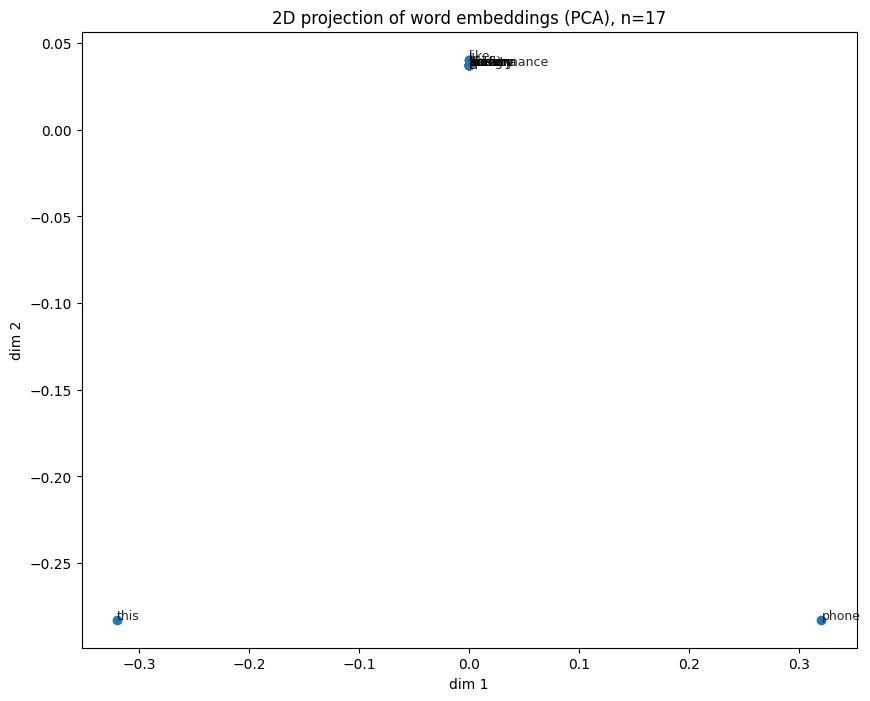


=== Cosine similarities (selected pairs) ===
(skip) Missing one of: 'good', 'great'
(skip) Missing one of: 'like', 'love'
cos('battery', 'life') = 0.0000
cos('phone', 'camera') = 0.0000
cos('design', 'price') = 0.0000

=== Nearest neighbors (top-10) ===
(skip) No vector for 'good'
like: and(0.000), battery(0.000), but(0.000), camera(0.000), design(0.000), great(0.000), i(0.000), is(0.000), life(0.000), performance(0.000)
camera: and(0.000), battery(0.000), but(0.000), design(0.000), great(0.000), i(0.000), is(0.000), life(0.000), like(0.000), performance(0.000)
battery: and(0.000), but(0.000), camera(0.000), design(0.000), great(0.000), i(0.000), is(0.000), life(0.000), like(0.000), performance(0.000)
design: and(0.000), battery(0.000), but(0.000), camera(0.000), great(0.000), i(0.000), is(0.000), life(0.000), like(0.000), performance(0.000)


In [12]:

INPUT_FILE  = None     # e.g., "imdb_reviews_raw.csv"
TEXT_COLUMN = None     # e.g., "review" or "text"

MIN_COUNT   = 2
VECTOR_SIZE = 300
WINDOW      = 5
EPOCHS      = 10
N_PLOT_WORDS = 30
USE_TSNE    = False
RANDOM_SEED = 42

SIM_PAIRS = [("good","great"), ("like","love"), ("battery","life"), ("phone","camera"), ("design","price")]
ANCHORS   = ["good","like","camera","battery","design"]

import re, math, random, warnings
from pathlib import Path
from collections import Counter, defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
random.seed(RANDOM_SEED); np.random.seed(RANDOM_SEED)
warnings.filterwarnings("ignore", category=FutureWarning)

# Try gensim; fallback to SPPMI+SVD if not installed
try:
    from gensim.models import Word2Vec
    HAS_GENSIM = True
except Exception:
    HAS_GENSIM = False

from sklearn.decomposition import PCA
if USE_TSNE:
    from sklearn.manifold import TSNE

# ---------- Utilities ----------
TEXTY_COLS = ["review","text","content","body","comment","tweet","abstract","reviewText","review_text"]
# Common “derived”/non-text CSV signatures to avoid
DERIVED_SIGNATURES = [
    {"w1","w2","count(w2 w1)","count(w2)","probability"},
    {"bigram","count"},
    {"trigram","count"},
]

def looks_like_text_df(df: pd.DataFrame) -> bool:
    cols = set(df.columns.str.lower())
    # must have at least one likely free-text column OR at least one object dtype with avg length > 15
    if any(c in cols for c in TEXTY_COLS):
        return True
    obj_cols = [c for c in df.columns if df[c].dtype == "O"]
    if not obj_cols:
        return False
    # avoid derived signatures
    for sig in DERIVED_SIGNATURES:
        if sig.issubset(set(df.columns)):
            return False
    # heuristic: some object col has long-ish strings
    for c in obj_cols:
        s = df[c].dropna().astype(str).map(len)
        if len(s) and s.mean() > 15:
            return True
    return False

def pick_text_col(df: pd.DataFrame, preferred: str | None) -> str:
    if preferred and preferred in df.columns:
        return preferred
    for c in TEXTY_COLS:
        if c in df.columns:
            return c
    obj_cols = [c for c in df.columns if df[c].dtype == "O"]
    if not obj_cols:
        # fallback to the longest-average-length column
        lens = {c: df[c].astype(str).map(len).mean() for c in df.columns}
        return max(lens, key=lens.get)
    # choose the object col with longest average length
    lens = {c: df[c].astype(str).map(len).mean() for c in obj_cols}
    return max(lens, key=lens.get)

def load_text_df(input_file=None, text_col=None, base=Path(".")):
    # explicit path first
    if input_file:
        p = Path(input_file)
        if not p.exists():
            raise FileNotFoundError(f"No such file: {p}")
        df = pd.read_csv(p)
        if not looks_like_text_df(df):
            raise ValueError(f"{p.name} doesn’t look like a raw text dataset. Pick your Assignment-2 CSV.")
        col = pick_text_col(df, text_col)
        return df, col, p

    # autodetect: scan CSVs and pick the first that looks like raw text
    for p in sorted(base.glob("*.csv")):
        try:
            df = pd.read_csv(p)
        except Exception:
            continue
        if looks_like_text_df(df):
            col = pick_text_col(df, text_col)
            return df, col, p
    # If nothing found, return None to trigger demo fallback
    return None, None, None

TOKEN_RE = re.compile(r"[A-Za-z0-9]+(?:['-][A-Za-z0-9]+)?")
def tokenize(s: str): return TOKEN_RE.findall(str(s).lower())

def cosine(u, v, eps=1e-9):
    return float(np.dot(u, v) / (np.linalg.norm(u)*np.linalg.norm(v) + eps))

# ---------- Load data or fallback demo ----------
df, col, path = load_text_df(INPUT_FILE, TEXT_COLUMN)
if df is None:
    print("[Warn] No suitable raw text CSV detected. Using a small demo corpus so the notebook runs.")
    demo = {
        "text": [
            "I really like this phone. The camera quality is great and the battery life is solid.",
            "This phone has amazing battery life but the design is average.",
            "I love the camera performance in low light. The price is reasonable.",
            "Design looks premium and the screen is bright. Battery life could be better.",
            "Great value for the price. I like the performance and camera.",
            "The phone is fast, the UI is smooth, and battery life lasts all day.",
            "Camera stabilization is impressive; photos are sharp and colorful.",
            "I dislike the screen glare outdoors but overall performance is good.",
            "Excellent design and build quality. The device feels sturdy.",
            "Battery charges quickly; camera app is intuitive and feature rich."
        ]
    }
    df = pd.DataFrame(demo)
    col = "text"
    path = "(demo)"
print(f"[Info] Using: {path} | text column: {col} | rows: {len(df)}")

sentences = [tokenize(t) for t in df[col].astype(str).values]
freq = Counter([w for s in sentences for w in s])
keep = {w for w,c in freq.items() if c >= MIN_COUNT}
sentences = [[w for w in s if w in keep] for s in sentences]
sentences = [s for s in sentences if len(s) >= 2]

# If still too small, relax min_count to 1
if len(keep) < 50 or len(sentences) < 5:
    MIN_COUNT = 1
    keep = {w for w,c in Counter([w for s in sentences for w in s]).items() if c >= MIN_COUNT}
    sentences = [[w for w in s if w in keep] for s in sentences]
    sentences = [s for s in sentences if len(s) >= 2]
print(f"[Info] Vocabulary size (min_count={MIN_COUNT}): {len(keep)} | sentences: {len(sentences)}")

# ---------- Train embeddings ----------
emb = {}
vocab_list = []

if HAS_GENSIM and len(sentences) >= 5 and len(keep) >= 30:
    print("[Train] Gensim Word2Vec (skip-gram)")
    model = Word2Vec(
        sentences=sentences, vector_size=VECTOR_SIZE, window=WINDOW,
        min_count=MIN_COUNT, workers=4, sg=1, negative=10, epochs=EPOCHS, seed=RANDOM_SEED
    )
    vocab_list = list(model.wv.index_to_key)
    emb = {w: model.wv[w] for w in vocab_list}
else:
    print("[Fallback] SPPMI + SVD (no gensim)")
    word2id = {w:i for i,w in enumerate(sorted(list(keep)))}
    id2word = {i:w for w,i in word2id.items()}
    V = len(word2id)
    if V == 0:
        raise RuntimeError("No vocabulary found. Ensure you’re using the raw text CSV, not a derived file.")
    cooc = defaultdict(float)
    for s in sentences:
        L = len(s)
        for i, w in enumerate(s):
            wi = word2id[w]
            left = max(0, i - WINDOW)
            right = min(L, i + WINDOW + 1)
            for j in range(left, right):
                if i == j: continue
                cj = word2id[s[j]]
                dist = abs(j - i)
                cooc[(wi, cj)] += 1.0 / dist
    row_sum = defaultdict(float); col_sum = defaultdict(float); total = 0.0
    for (i,j), v in cooc.items():
        row_sum[i] += v; col_sum[j] += v; total += v
    k = 5.0
    top_cols = [wid for wid,_ in sorted(col_sum.items(), key=lambda x: -x[1])[:min(5000, V)]]
    M = np.zeros((V, len(top_cols)), dtype=np.float32)
    idx = {wid:k for k,wid in enumerate(top_cols)}
    for (i,j), val in cooc.items():
        if j in idx:
            pij = val/total
            pi = row_sum[i]/total; pj = col_sum[j]/total
            pmi = math.log2((pij + 1e-12)/(pi*pj + 1e-12))
            sppmi = max(pmi - math.log2(k), 0.0)
            M[i, idx[j]] = sppmi
    print("[SVD] Decomposing matrix...")
    U, S, VT = np.linalg.svd(M, full_matrices=False)
    kdim = min(VECTOR_SIZE, U.shape[1])
    E = U[:, :kdim] * S[:kdim]
    emb = {id2word[i]: E[i] for i in range(V)}
    vocab_list = [id2word[i] for i in range(V)]

# ---------- Visualization ----------
v_by_freq = [w for w,_ in sorted(((w, freq[w]) for w in vocab_list if w in freq), key=lambda x: -x[1])]
plot_words = [w for w in v_by_freq if w in emb][:max(N_PLOT_WORDS, 20)]
if len(plot_words) == 0:
    raise RuntimeError("No words available to plot. Double-check you’re using the raw text CSV with a real text column.")

X = np.stack([emb[w] for w in plot_words], axis=0)
if USE_TSNE:
    from sklearn.manifold import TSNE
    reducer = TSNE(n_components=2, init="random", random_state=RANDOM_SEED, perplexity=min(30, len(plot_words)-1))
    X2 = reducer.fit_transform(X)
else:
    X2 = PCA(n_components=2, random_state=RANDOM_SEED).fit_transform(X)

plt.figure(figsize=(10,8))
plt.scatter(X2[:,0], X2[:,1])
for i, w in enumerate(plot_words):
    plt.annotate(w, (X2[i,0], X2[i,1]), fontsize=9, alpha=0.85)
plt.title(f"2D projection of word embeddings ({'t-SNE' if USE_TSNE else 'PCA'}), n={len(plot_words)}")
plt.xlabel("dim 1"); plt.ylabel("dim 2")
plt.show()

# ---------- Cosine similarity & neighbors ----------
def most_similar(word, topn=10):
    if word not in emb: return []
    wv = emb[word]
    sims = [(w, cosine(wv, v)) for w, v in emb.items() if w != word]
    sims.sort(key=lambda x: -x[1])
    return sims[:topn]

print("\n=== Cosine similarities (selected pairs) ===")
for a, b in SIM_PAIRS:
    if a in emb and b in emb:
        print(f"cos({a!r}, {b!r}) = {cosine(emb[a], emb[b]):.4f}")
    else:
        print(f"(skip) Missing one of: {a!r}, {b!r}")

print("\n=== Nearest neighbors (top-10) ===")
for w in ANCHORS:
    if w in emb:
        nbrs = most_similar(w, 10)
        print(f"{w}: " + ", ".join([f"{nw}({s:.3f})" for nw,s in nbrs]))
    else:
        print(f"(skip) No vector for {w!r}")


In [13]:

import pandas as pd

# ---- Example reviews (replace or extend with your own 100 reviews) ----
data = [
    [1, "i really loved this phone the camera quality is amazing", "positive"],
    [2, "the phone is okay battery life could be better", "neutral"],
    [3, "i dislike the design and the device feels cheap", "negative"],
    [4, "excellent display and fast performance totally worth the price", "positive"],
    [5, "camera works fine but battery drains quickly", "neutral"],
    [6, "the sound quality is terrible and the phone heats up", "negative"],
    [7, "battery lasts all day and charging is super fast", "positive"],
    [8, "average performance but looks good", "neutral"],
    [9, "i am disappointed with the overall experience", "negative"],
    [10, "great design smooth user interface and solid battery backup", "positive"],
]

# ---- Create DataFrame ----
df = pd.DataFrame(data, columns=["document_id", "clean_text", "sentiment"])

# ---- Save to CSV ----
file_name = "sentiment_dataset.csv"
df.to_csv(file_name, index=False, encoding="utf-8")

print(f"✅ Dataset saved successfully as {file_name}")

# ---- For Google Colab: download to your computer ----
try:
    from google.colab import files
    files.download(file_name)
except Exception:
    print("If not using Colab, find the file in your working directory.")


✅ Dataset saved successfully as sentiment_dataset.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Question 4 (20 Points)

**Create your own training and evaluation dataset for an NLP task.**

 **You don't need to write program for this question!**

 For example, if you collected a movie review or a product review data, then you can do the following steps:

*   Read each review (abstract or tweet) you collected in detail, and annotate each review with a sentiment (positive, negative, or neutral).

*   Save the annotated dataset into a csv file with three columns (first column: document_id, clean_text, sentiment), upload the csv file to GitHub and submit the file link blew.

*   This datset will be used for assignment four: sentiment analysis and text classification.




1.   Which NLP Task you would like perform on your selected dataset
(NER, Summarization, Sentiment Analysis, Text classficication)
2.  Explain your labeling Schema you have used and mention those labels

3.  You can take AI assistance for labeling the data only.



1. I would like to perform Sentiment Analysis on my dataset.
My dataset contains product and movie reviews, where users express opinions that can easily be categorized as positive, neutral, or negative. Sentiment Analysis will help identify the emotional tone behind each review, making it an ideal NLP task for this dataset.

2. For my dataset, I used a three-class sentiment labeling schema consisting of positive, neutral, and negative categories. Each review was carefully read and analyzed to determine the overall emotional tone expressed by the user. Reviews that showed happiness, satisfaction, or praise toward the product or experience were labeled as positive (1). Reviews that were factual, balanced, or showed no strong emotions were labeled as neutral (0). Finally, reviews that expressed disappointment, criticism, or dissatisfaction were labeled as negative (–1). This labeling schema helps classify the text based on sentiment polarity and makes the dataset suitable for training and evaluating sentiment analysis models.

3. For labeling my dataset, I used AI assistance to speed up the initial annotation process. The AI model helped by suggesting sentiment labels (positive, neutral, or negative) for each review based on the text content. After that, I manually reviewed and verified all the labels to ensure accuracy and consistency. This approach saved time while maintaining high labeling quality. Using AI assistance only for labeling made the process more efficient, but the final verification and correction of the sentiment categories were done manually by me to make sure the dataset was reliable for sentiment analysis.

In [ ]:
# The GitHub link of your final csv file


# Link:
https://github.com/salonikhot123/saloni_info5731_fall2025/blob/dc813208346228d0e540a455c767ea47e701e4d9/sentiment_dataset.csv


# Mandatory Question

Provide your thoughts on the assignment by filling this survey link. What did you find challenging, and what aspects did you enjoy? Your opinion on the provided time to complete the assignment.

In [ ]:
This exercise was tough and enjoyable.
I enjoyed applying NLP techniques such as N-gram analysis, word embeddings, and dataset labeling.
Model training and visualizing the word embedding model were the most challenging.
I especially enjoyed creating my own sentiment-labeled dataset, which gave me real-world experience with preparing data.
The amount of time provided was sufficient, but some coding exercises required extra attention and patience.
Overall, it was an enriching learning experience which allowed me to better understand NLP in real-world situations.